In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing import image
from keras.utils import load_img, img_to_array
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from IPython.display import Image
import itertools
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline
import os
# os.chdir('../../data')

In [2]:
mboileNet = tf.keras.applications.mobilenet.MobileNet()

2022-10-06 01:43:58.090552: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-10-06 01:43:58.090620: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sheded-Latitude-E6520): /proc/driver/nvidia/version does not exist


In [19]:
def prepare_image(img_name):
    img_path = '/home/sheded/DataspellProjects/computer vision/data/mobileNet/'
    img = load_img(img_path+img_name, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

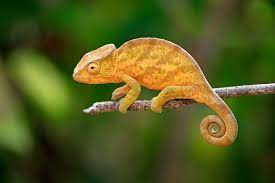

In [17]:
Image(filename='mobileNet/hr.jpg', width=450, height=300)

In [20]:
preprocessed_image = prepare_image('hr.jpg')
predictions = mboileNet.predict(preprocessed_image)

1/1 [==============================] - 1s 757ms/step


In [23]:
results = imagenet_utils.decode_predictions(predictions)

35363/35363 [==============================] - 0s 2us/step


In [24]:
results

[[('n01694178', 'African_chameleon', 0.99809724),
  ('n01675722', 'banded_gecko', 0.0018332386),
  ('n01630670', 'common_newt', 2.9890416e-05),
  ('n01644900', 'tailed_frog', 1.6897622e-05),
  ('n01685808', 'whiptail', 1.0182522e-05)]]